# CATE Estimation with Causal Forest

This notebook provides a practical comparison of several methods for estimating Conditional Average Treatment Effects (CATE) using simulated data.  

We explore how different models perform under various data-generating processes, from simple linear relationships to complex scenarios with unobserved heterogeneity. 

This is particularly relevant for applications like personalized marketing, dynamic pricing, or customized user interventions where understanding *"for whom"* an action is effective is critical.

---
## 1. Introduction to CATE Estimation

In many business and research settings, the goal is not just to measure the Average Treatment Effect (ATE) of an intervention, but to understand how this effect varies across individuals with different characteristics.  
This heterogeneous effect is the **Conditional Average Treatment Effect**, or **CATE**, denoted as $\tau(x)$.

Mathematically, it is defined as the expected difference in potential outcomes for an individual with covariates $X = x$:

$$
\tau(x) = \mathbb{E}[Y(1) - Y(0) \mid X = x]
$$

where $Y(1)$ is the potential outcome if treated and $Y(0)$ is the potential outcome if not treated.  
Our goal is to use data to build a model that can accurately estimate $\tau(x)$ for any given individual.

---
## 2. CATE Estimation Methods

We will compare a set of models ranging from traditional econometric methods to modern machine learning estimators.

### 2.1. Linear Model (with Regularization)

A flexible linear model serves as a strong baseline. To capture non-linearities and interactions, we first pre-process the features.  
Continuous variables are binned, and high-cardinality categorical variables are one-hot encoded.  
We then fit a linear model that includes interaction terms between the treatment and these processed features.

The model is specified as:

$$
Y = \beta_0 + f(X)\beta_1 + T\delta + (T \cdot f(X))\gamma + \epsilon
$$

where $f(X)$ represents the feature transformation (binning and encoding).  
The CATE is then reconstructed from the fitted coefficients:

$$
\hat{\tau}(x) = \hat{\delta} + f(x)\hat{\gamma}
$$

We use `LassoCV` to handle the high dimensionality of $f(X)$ and perform automatic feature selection via L1 regularization.

### 2.2. K-Nearest Neighbors (KNN) Regression

K-Nearest Neighbors (KNN) regression is a classic non-parametric method that estimates outcomes locally.  
Instead of fitting a global model, it makes predictions for a new data point by looking at the $k$ most similar data points (neighbors) from the training set in the feature space.

We implement a T-Learner version of this approach:

1. Split the data into treated ($T = 1$) and control ($T = 0$) groups.  
2. Fit two separate KNN regression models to predict the outcome in each group:

   $$
   \hat{\mu}_1(x) = \text{Average}(Y_i \mid i \in k\text{-NN}(x), T_i = 1)
   \quad \text{and} \quad
   \hat{\mu}_0(x) = \text{Average}(Y_i \mid i \in k\text{-NN}(x), T_i = 0)
   $$

3. The CATE is the difference between the predictions of these two models:

   $$
   \hat{\tau}(x) = \hat{\mu}_1(x) - \hat{\mu}_0(x)
   $$

The prediction for a point $x$ is typically a weighted average of the outcomes of its neighbors,  
where closer neighbors are given more weight (e.g., `weights='distance'`).  

### 2.3. Causal Forest

The Causal Forest, developed by Athey and Wager, is a non-parametric method based on an ensemble of "honest" trees (use one subsample to choose splits and a disjoint subsample to estimate leaf effects; this reduces bias and enables valid inference).
Causal forests (or Generalized Random Forests, GRF) grow honest trees on orthogonalized data and choose splits that maximize heterogeneity in treatment effects, yielding consistent CATE under overlap.

**Intuition for splitting:** First remove what $X$ explains from both outcome and treatment:
$$
Y-\hat m(X),\quad T-\hat e(X).
$$
Their scaled product
$$
U=\frac{(Y-\hat m(X))(T-\hat e(X))}{\hat e(X)[1-\hat e(X)]}
$$
acts like a local “effect signal.” Positive $U$: treated did better than expected given $X$. Negative $U$: treated did worse.

A good split groups similar signals together. If one child has mostly positive $U$ and the other mostly negative, heterogeneity is high. A simple teaching proxy is
$$
S=\frac{n_L n_R}{n}\big(\bar U_L-\bar U_R\big)^2,
$$
which is large when child means of $U$ are far apart and both children are sizable. Equal means give $S\approx0$. In practice GRF optimizes a closely related orthogonalized criterion rather than a literal regression tree on $U$.

**Setup:** Estimate nuisance functions $m(x)=\mathbb E[Y\mid X=x]$ and $e(x)=\mathbb P(T=1\mid X=x)$ (in an RCT with assignment rate $p$, set $e(x)=p$).

**Pseudo-outcome:** Using $U_i$ defined above,
$$
\mathbb E[U_i\mid X_i=x]=\tau(x).
$$

**Prediction:** For a query $x$, aggregate leaf estimates across trees to get $\hat\tau(x)$. Forest weights act as adaptive nearest neighbors.

**Assumptions:** SUTVA; overlap $0<e(X)<1$; randomization or unconfoundedness $Y(t)\perp T\mid X$. Consistency holds with accurate nuisance functions and honesty.

## 3. Evaluation Metrics

To evaluate our models, we use two complementary metrics:

- **CATE Mean Squared Error (MSE)**: This measures the overall accuracy of the CATE predictions against the known ground truth from the simulation.  
  It provides a single score for a model’s predictive power.

- **Uplift Decile Chart**: This is a business-oriented metric that evaluates a model’s ability to rank users from most to least responsive.  
  It directly answers the question: “If I target the top 10% of users as ranked by my model, do they actually have the highest treatment effect?”  
  A good model will show a strong upward trend, indicating that its ranking is meaningful.

---
## 4. Simulation Scenarios

We will test our models under three distinct data-generating processes (DGPs).

### Scenario 1: Linear Heterogeneity

This is the simplest case. The true CATE is a linear function of the observed features.  
This scenario should favor the linear models.

### Scenario 2: Non-linear Heterogeneity

This is a more realistic and challenging scenario. The true CATE is a complex function of the features,  
involving sharp conditional logic (`if/else`), non-linear transformations (`sin`), and deep interactions.  
This is the type of structure that tree-based, non-parametric models are designed to uncover.

### Scenario 3: Unobserved Heterogeneity (Boomerang Effect)

This is the most difficult scenario and a critical test of model diagnostics.  
The treatment effect is primarily driven by an unobserved variable (`user_latent_preference`).  
Furthermore, this hidden variable flips the sign of the effect for half the population, creating a **"boomerang effect"** where the treatment is beneficial for some and harmful for others.

In this case, the Average Treatment Effect (ATE) will be close to zero. Under randomization an A/B test gives an unbiased ATE; a near-zero ATE can still mask offsetting subgroup effects.
We expect all CATE models to fail in terms of predictive accuracy (high MSE),  
but the Uplift Decile Chart becomes a crucial diagnostic tool.  
A flat uplift chart will signal that the model has no ranking power, indicating that a key driver of heterogeneity is missing from the data.

---
## 5. Code

### 5.1. Setup
First, we import the necessary libraries and define the global settings for our experiments. We will be using *econml* for the Causal Forest and *sklearn* for baseline models and utilities.

In [272]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor

from econml.grf import CausalForest

from statsmodels.nonparametric.kernel_regression import KernelReg

import matplotlib.pyplot as plt

N_SAMPLES = 50_000
MODELS = [
  'Linear Model (binned, lasso)',
  'KNN Regression',
  'Causal Forest',
]

np.random.seed(42)

### 5.2. Functions for Plots

In [273]:
def plot_scatter_cate(true_cate, cate_pred, ax, title, mse):
    p = np.asarray(cate_pred).ravel()
    true_c = np.asarray(true_cate).ravel()

    ax.scatter(true_c, p, alpha=0.3, s=12, edgecolors='none')
    min_val = min(true_c.min(), p.min())
    max_val = max(true_c.max(), p.max())
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
    ax.set_title(f"{title} (MSE: {mse:.2f})")
    ax.set_xlabel("True CATE")
    ax.grid(True, alpha=0.4)
    ax.legend(frameon=False, fontsize=8)
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.set_aspect('equal', 'box') 
    ax.set_xlabel(""); ax.set_ylabel("")

In [ ]:
def plot_uplift_quartiles(true_cate, cate_pred, ax, title, n_bins=4):
    p = np.asarray(cate_pred).ravel()
    true_c = np.asarray(true_cate).ravel()

    df = pd.DataFrame({"predicted_cate": p, "true_cate": true_c})

    df["true_cate_quartile"] = pd.qcut(df["true_cate"], n_bins, labels=False, duplicates='drop')

    bars = df.groupby("true_cate_quartile")["predicted_cate"].mean()

    bars = bars.reindex(range(n_bins), fill_value=0)

    x_ticks = np.arange(1, n_bins + 1)
    ax.bar(x_ticks, bars.values, color="#8c564b", width=0.8)

    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks(x_ticks)
    ax.axhline(0, linewidth=1, color='black')
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.set_xlabel(""); ax.set_ylabel("")

In [ ]:
def make_plots(models_results, true_cate_test, title_suffix):
    fig = plt.figure(figsize=(11, 8.5), constrained_layout=True)
    fig.suptitle(f"CATE Prediction Performance: {title_suffix}", fontsize=16)

    num_models = len(models_results)

    sub_top, sub_bot = fig.subfigures(2, 1, hspace=0.1, height_ratios=[1, 0.7])

    axs_top = sub_top.subplots(1, num_models, sharex=True, sharey=True)
    axs_bot = sub_bot.subplots(1, num_models, sharex=True, sharey=True)

    # Ensure axs are always iterable, even for a single model
    if num_models == 1:
        axs_top = [axs_top]
        axs_bot = [axs_bot]

    # row 1: Scatter plot of Predicted CATE vs True CATE
    for ax, (name, (preds, mse)) in zip(axs_top, models_results.items()):
        plot_scatter_cate(true_cate_test, preds, ax, name, mse)

    # ADD THIS LINE (after sub_bot is created)
    sub_bot.suptitle("Predicted CATE by True CATE Quartile", y=1.1, fontsize=15)

    # row 2: Uplift Decile Chart
    for ax, (name, (preds, _)) in zip(axs_bot, models_results.items()):
        plot_uplift_quartiles(true_cate_test, preds, ax, name)

    # shared labels per row
    sub_top.supylabel("Predicted CATE")
    sub_top.supxlabel("True CATE", y=0.03)

    sub_bot.supylabel("Average Predicted CATE")
    sub_bot.supxlabel("True CATE Quartile", y=-0.08)

### 5.3 Training Models

In [276]:
def analyze_cate_estimation(simulated_data, title_suffix=""):
    """
    Trains models, evaluates CATE performance via MSE and uplift charts.
    """

    # --- 1. Prepare Data ---
    X = simulated_data[['age', 'geo', 'past_month_engagement']]
    t = simulated_data['treatment']
    y = simulated_data['spending']
    true_cate = simulated_data['true_cate']

    X_train, X_test, t_train, t_test, y_train, y_test, true_cate_train, true_cate_test = \
        train_test_split(X, t, y, true_cate, test_size=0.5, random_state=42)

    # --- 2. Model Training and CATE Prediction ---
    models_results = {}

    if 'Linear Model (binned, lasso)' in MODELS:
        # Since 'geo' is numeric, binning it is more consistent with the other features
        preprocessor = ColumnTransformer(
            transformers=[
                ('age_binner', KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='quantile'), ['age']),
                ('eng_binner', KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='quantile'), ['past_month_engagement']),
                ('geo_binner', KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile'), ['geo'])
            ],
            remainder='drop'
        )
        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        t_train_col = t_train.values.reshape(-1, 1)
        design_matrix_lasso_train = np.c_[X_train_processed, t_train_col, X_train_processed * t_train_col]
        model_bins = LassoCV(cv=5, random_state=42, max_iter=2000)
        model_bins.fit(design_matrix_lasso_train, y_train)
        num_processed_features = X_train_processed.shape[1]
        coef_t_lasso = model_bins.coef_[num_processed_features]
        coef_tX_lasso = model_bins.coef_[num_processed_features + 1:]
        predicted_cate_lasso = coef_t_lasso + X_test_processed @ coef_tX_lasso
        models_results['Linear (binned, lasso)'] = (predicted_cate_lasso, mean_squared_error(true_cate_test, predicted_cate_lasso))

    if 'KNN Regression' in MODELS:
        # Use a preprocessor to scale all numeric features for KNN
        preprocessor_knn = StandardScaler()
        X_train_scaled = preprocessor_knn.fit_transform(X_train)
        X_test_scaled = preprocessor_knn.transform(X_test)
        model_knn_treated = KNeighborsRegressor(n_neighbors=50, weights='distance')
        model_knn_treated.fit(X_train_scaled[t_train == 1], y_train[t_train == 1])
        model_knn_control = KNeighborsRegressor(n_neighbors=50, weights='distance')
        model_knn_control.fit(X_train_scaled[t_train == 0], y_train[t_train == 0])
        y1_pred = model_knn_treated.predict(X_test_scaled)
        y0_pred = model_knn_control.predict(X_test_scaled)
        predicted_cate_knn = y1_pred - y0_pred
        models_results['KNN Regression'] = (predicted_cate_knn, mean_squared_error(true_cate_test, predicted_cate_knn))

    if 'Causal Forest' in MODELS:
        # CausalForest handles numeric features directly
        model_forest = CausalForest(random_state=42, criterion='het', n_estimators=500, min_samples_leaf=10, max_depth=10)
        model_forest.fit(X_train, t_train, y_train)
        predicted_cate_forest = np.asarray(model_forest.predict(X_test)).ravel()
        models_results['Causal Forest'] = (predicted_cate_forest, mean_squared_error(true_cate_test, predicted_cate_forest))

    # --- 3. Visualization ---
    make_plots(models_results, true_cate_test, title_suffix)
    

### 5.4 Data Generating Process

In [277]:
def generate_linear_cate_data(base_data):
    """Generates data with a linear CATE function."""
    data = base_data.copy()
    data['true_cate'] = 5 + 0.2 * (data['age'] - 18) + 0.1 * (data['past_month_engagement'] - 100)
    data['spending'] = data['baseline_spending'] + data['treatment'] * data['true_cate']
    return data

def generate_nonlinear_cate_data(base_data):
    """Generates data with a non-linear CATE function."""
    data = base_data.copy()
    age = data['age']
    engagement = data['past_month_engagement']
    geo = data['geo']
    effect = 5.0
    effect += np.where(age > 45, 0.2 * (engagement - 100), 0.05 * (engagement - 100))
    effect += np.where((200 < geo) & (geo < 600), 6 * np.sin(age / 5), 0)
    effect += np.where((engagement > 120) & (geo > 800), 7, 0)
    data['true_cate'] = np.maximum(0, effect)
    data['spending'] = data['baseline_spending'] + data['treatment'] * data['true_cate']
    return data
    
def generate_unobserved_heterogeneity_cate_data(base_data):
    """Generates data where CATE is a function of an unobservable user preference."""
    data = generate_linear_cate_data(base_data)
    data['user_latent_preference'] = np.random.uniform(0, 1, len(data))
    data['true_cate'] = np.where(
        data['user_latent_preference'] >= 0.5,
        -data['true_cate'],
        data['true_cate']
    )
    data['spending'] = data['baseline_spending'] + data['treatment'] * data['true_cate']
    return data
    

# Simulate baseline data
simulated_data_base = pd.DataFrame({
    'age': np.random.uniform(18, 70, N_SAMPLES).astype(int),
    'geo': np.random.uniform(1, 1000, N_SAMPLES).astype(int),
    'past_month_engagement': np.maximum(0, np.random.normal(100, 20, N_SAMPLES)),
    'treatment': np.random.choice([0, 1], N_SAMPLES)
})
simulated_data_base['baseline_spending'] = 10 + 0.5 * simulated_data_base['age'] + np.random.normal(0, 5, N_SAMPLES)

simulated_data_linear_het = generate_linear_cate_data(simulated_data_base)    
simulated_data_nonlinear_het = generate_nonlinear_cate_data(simulated_data_base)
simulated_data_unobserved_het = generate_unobserved_heterogeneity_cate_data(simulated_data_base)

## 6. Results

### Scenario 1: Linear Heterogeneity

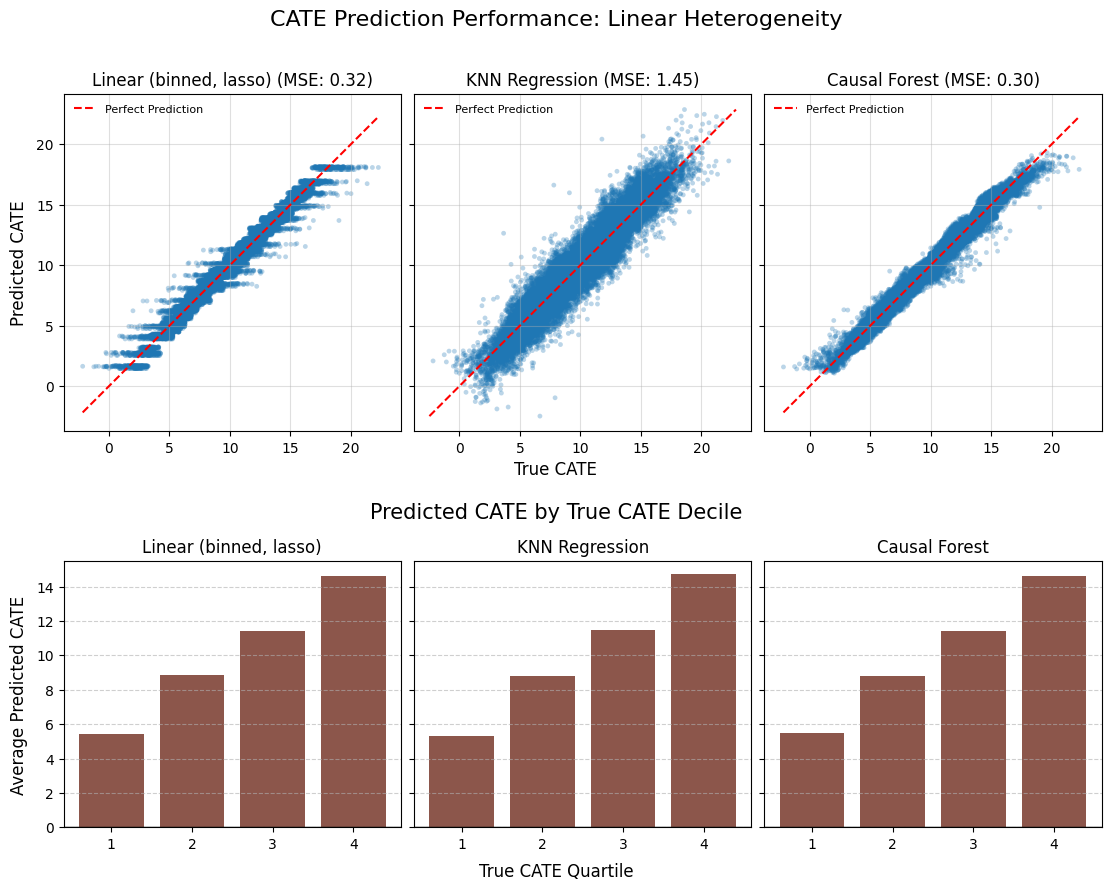

In [278]:
analyze_cate_estimation(simulated_data_linear_het, "Linear Heterogeneity")

**Comments:** 

Under linear heterogeneity the signal is smooth and mostly additive, so all three learners recover it: the causal forest approximates the line with many honest splits, the penalized linear model fits it directly (with some bias from binning/L1), and KNN averages locally. That’s why CATE MSE is low for all, with CF best, linear close, and KNN worst. More important for targeting, each model ranks users correctly (the uplift quartiles rise monotonically) so any of them would prioritize high-effect users well in this DGP. 

In short: linear heterogeneity $\implies$ broad model success.

---
### Scenario 2: Non-Linear Heterogeneity

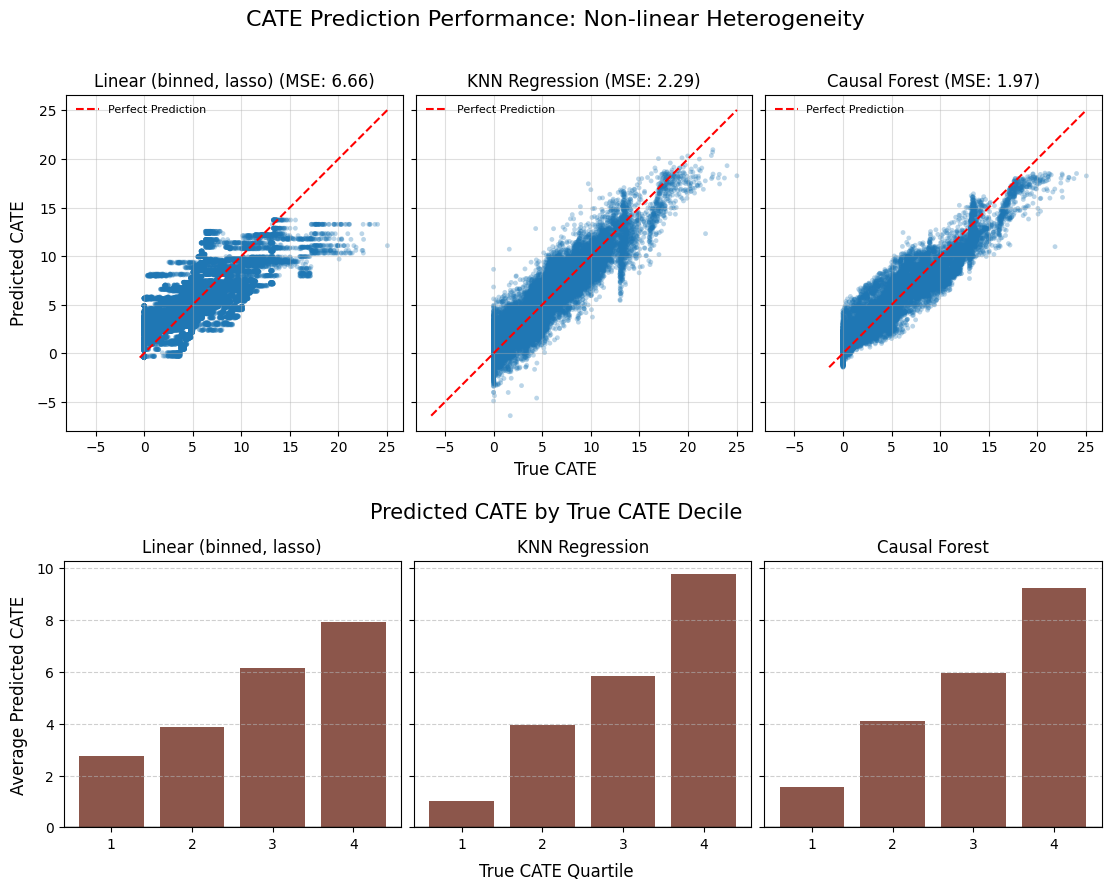

In [279]:
analyze_cate_estimation(simulated_data_nonlinear_het, "Non-linear Heterogeneity")

**Comments:**

Non-linear heterogeneity favors flexible models. In this scenario, we have many non-linearities in CATE (age > 45 changes slope; geo between 200–600 adds a sine term; the high-engagement×high-geo rule adds a step) plus rectification at 0. The linear+binned Lasso is misspecified, so it saturates and underestimates extremes and shows the weakest quartile slope. KNN locally averages, so it tracks smooth parts but blurs across boundaries and bands; uplift quartiles are cleanly monotone. Causal forest captures thresholds and interactions via splits (age gate, geo band, engagement×geo rule), so it fits best and yields the steepest uplift curve. 

In short: under non-linear heterogeneity, CF > KNN > linear; all still rank reasonably, with CF strongest.

---
### Scenario 3: Unobserved Heterogeneity

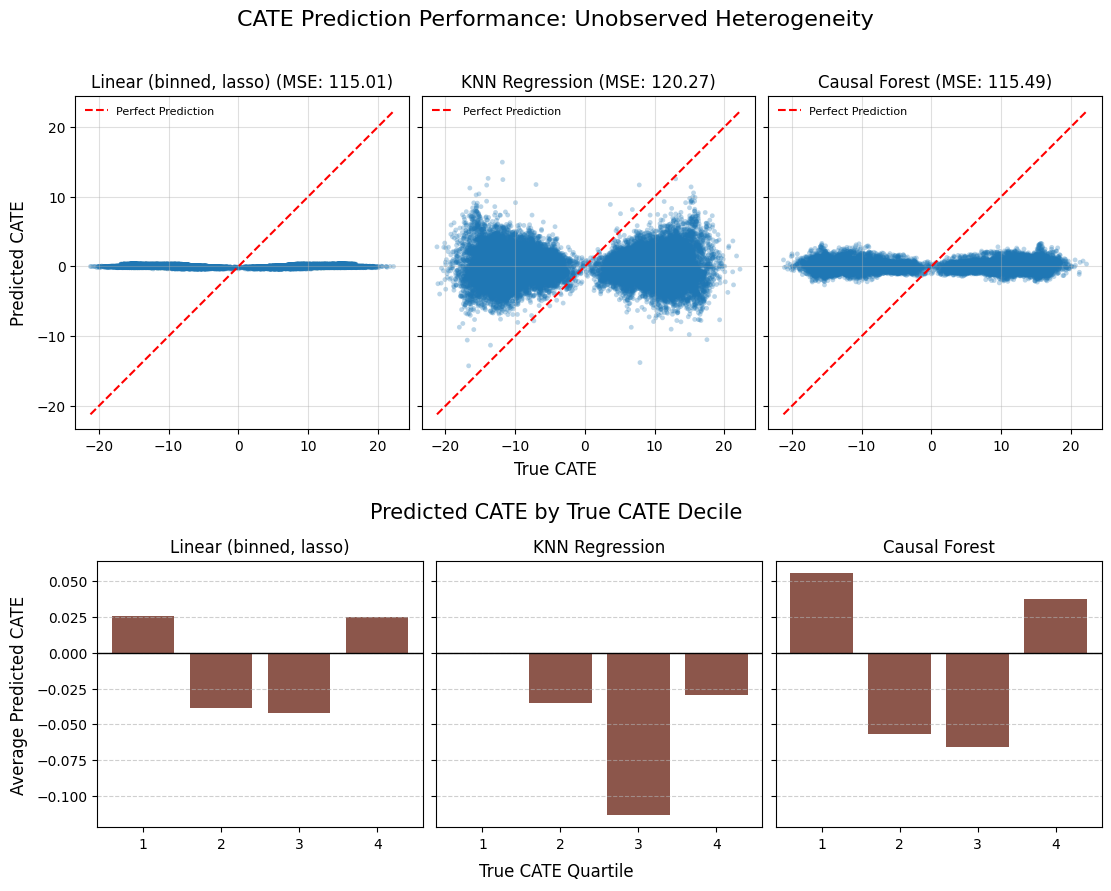

In [280]:
analyze_cate_estimation(simulated_data_unobserved_het, "Unobserved Heterogeneity")

**Comments:**

In this scenario the driver of treatment response is unobserved and flips the sign for half the users, so X contains almost no signal about $\tau(x)$. All three learners collapse toward zero predictions and MSE explodes because the true effects swing widely. The uplift quartiles hover near zero without a monotone pattern, indicating no ranking power; any apparent bumps are noise. An RCT would still estimate ATE unbiasedly, but that masks offsetting subgroup harms/benefits. 

In short: without features that proxy the latent preference, or a redesigned experiment to expose it, targeting is indistinguishable from random.